# Cell type differences and effects of interferon stimulation on immune cells

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [4]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
from sklearn.decomposition import PCA

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/scmemo')
import estimator, simulate, scmemo, bootstrap, util, hypothesis_test

In [9]:
fig_path = '/home/ssm-user/Github/scrna-parameter-estimation/figures/fig4/'
data_path = '/data/'

### Perform some basic filtering

In [10]:
cts = ['CD4 T cells',  'CD14+ Monocytes', 'FCGR3A+ Monocytes', 'NK cells','CD8 T cells', 'B cells']
label_converter = dict(zip(cts, ['Th', 'cM', 'ncM', 'NK', 'Tc', 'B']))

In [11]:
def simplify_name(name):
    return name.split('.')[0]

In [12]:
adata = sc.read(data_path + 'interferon.h5ad')
adata = adata[(adata.obs.multiplets == 'singlet') & (adata.obs.cell != 'nan'), :].copy()
adata.X = adata.X.astype(np.int64)

In [13]:
adata.obs.cell.value_counts()

CD4 T cells          10389
CD14+ Monocytes      5385 
B cells              2573 
CD8 T cells          2042 
NK cells             1993 
FCGR3A+ Monocytes    1599 
Dendritic cells      432  
Megakaryocytes       260  
Name: cell, dtype: int64

In [14]:
adata.obs['cell_type'] = (adata.obs['cell'].astype(str) + ' - ' + adata.obs['stim'].astype(str)).astype('category')

... storing 'ind' as categorical
... storing 'stim' as categorical
... storing 'cluster' as categorical
... storing 'cell' as categorical
... storing 'multiplets' as categorical


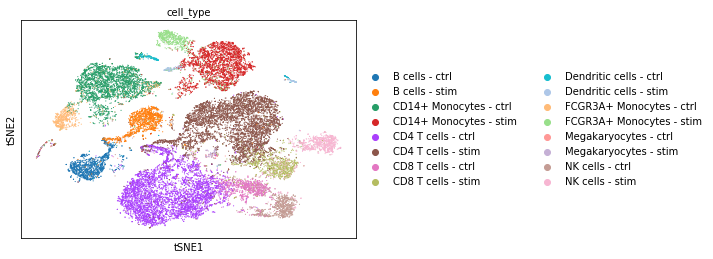

In [15]:
sc.pl.tsne(adata, color='cell_type')

In [16]:
# plt.figure(figsize=(5, 3))
# sns.boxplot(x='n_counts', y='cell_type', data=adata.obs)
# plt.title('Total UMI counts by cell type')
# plt.savefig('celltype_numi.pdf')
# plt.savefig('celltype_numi.png')

In [17]:
print('Number of genes kept:', adata.shape[1])

Number of genes kept: 35635


### Null distributions

In [961]:
imp.reload(scmemo)
imp.reload(bootstrap)
imp.reload(hypothesis_test)
imp.reload(util)

test_adata = adata[adata.obs.cell == 'B cells'].copy()
test_adata.obs['stim'] = np.random.choice(test_adata.obs['stim'], test_adata.shape[0])
scmemo.create_groups(test_adata, label_columns=['stim', 'ind'], inplace=True)
scmemo.compute_1d_moments(
    test_adata, inplace=True, filter_genes=True, 
    residual_var=True, use_n_umi=True, filter_mean_thresh=0.1, 
    min_perc_group=0.9)
print('Number of genes kept:{}'.format(test_adata.shape[1]))

Number of genes kept:924


In [962]:
size_factor = test_adata.uns['scmemo']['all_size_factor']
binned_stat = stats.binned_statistic(size_factor, size_factor, bins=50, statistic='mean')
bin_idx = np.clip(binned_stat[2], a_min=1, a_max=binned_stat[0].shape[0])
approx_sf = binned_stat[0][bin_idx-1]
max_sf = size_factor.max()
approx_sf[size_factor == max_sf] = max_sf
test_adata.uns['scmemo']['all_size_factor'] = approx_sf
# size_factor = approx_sf

In [963]:
actual_moments_1 = estimator._poisson_1d(
    test_adata[(test_adata.obs['stim'] == 'ctrl').values].X,
    (test_adata.obs['stim'] == 'ctrl').values.shape[0],
    size_factor[(test_adata.obs['stim'] == 'ctrl').values]
    )

actual_moments_2 = estimator._poisson_1d(
    test_adata[(test_adata.obs['stim'] == 'stim').values].X,
    (test_adata.obs['stim'] == 'stim').values.shape[0],
    size_factor[(test_adata.obs['stim'] == 'stim').values]
    )

In [964]:
%%time

num_boot = 100
moments_1, moments_2 = [], []
cell_count_1, cell_count_2 = [], []

for boot_trial in range(num_boot):
    boot_idxs = np.random.choice(test_adata.shape[0], test_adata.shape[0])
    
    boot_mat = test_adata.X[boot_idxs, :]
    boot_label = test_adata.obs['stim'][boot_idxs]
    size_factors = test_adata.uns['scmemo']['all_size_factor'][boot_idxs]
#     size_factors = approx_sf
    
    boot_idxs_1 = (boot_label == 'ctrl').values
    boot_idxs_2 = (boot_label == 'stim').values
    
    moments_1.append(
        estimator._poisson_1d(
            boot_mat[boot_idxs_1],
            boot_idxs_1.shape[0],
            size_factors[boot_idxs_1])
    )
    moments_2.append(
        estimator._poisson_1d(
            boot_mat[boot_idxs_2],
            boot_idxs_2.shape[0],
            size_factors[boot_idxs_2])
    )
    cell_count_1.append(boot_idxs_1.shape[0])
    cell_count_2.append(boot_idxs_2.shape[0])
    

CPU times: user 1.2 s, sys: 0 ns, total: 1.2 s
Wall time: 1.2 s


In [965]:
means_1, vars_1, means_2, vars_2 = [],[],[],[]
for boot_trial in range(num_boot):
    
    means_1.append(moments_1[boot_trial][0])
    vars_1.append(moments_1[boot_trial][1])

    means_2.append(moments_2[boot_trial][0])
    vars_2.append(moments_2[boot_trial][1])
    
means_1, vars_1, means_2, vars_2 = np.array(means_1), np.array(vars_1), np.array(means_2), np.array(vars_2)

var_add = 1000

vars_1 += var_add
vars_2 += var_add

actual_mean_diff = actual_moments_2[0] - actual_moments_1[0] 
actual_var_diff = np.sqrt(actual_moments_2[1]+var_add)/actual_moments_2[0] - np.sqrt(actual_moments_1[1]+var_add)/actual_moments_1[0]

# means_1 -= actual_moments_1[0]
# means_2 -= actual_moments_2[0]
# vars_1 -= actual_moments_1[1]
# vars_2 -= actual_moments_2[1]

mean_diff = means_2 - means_1
mean_diff -= actual_mean_diff

var_diff = np.sqrt(vars_2)/means_2 - np.sqrt(vars_1)/means_1
var_diff -= actual_var_diff

mean_pval = 2*np.minimum(1-(mean_diff > (actual_mean_diff)).mean(axis=0), (mean_diff > (actual_mean_diff)).mean(axis=0))
var_pval = 2*np.minimum(1-(var_diff > (actual_var_diff)).mean(axis=0), (var_diff > (actual_var_diff)).mean(axis=0))

(array([31., 35., 36., 25., 24., 29., 23., 24., 31., 27., 24., 17., 21.,
        22., 18., 18., 21., 14., 26., 11., 11., 27., 18., 13., 13., 18.,
        18., 16., 13., 15., 20., 31., 14.,  9., 26.,  0., 17.,  9., 11.,
        14., 20.,  4.,  9., 16., 14., 13., 23.,  0., 20., 15.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <a list of 50 Patch objects>)

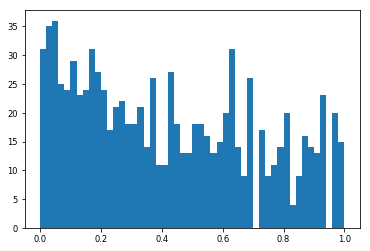

In [966]:
plt.hist(var_pval, bins=50)

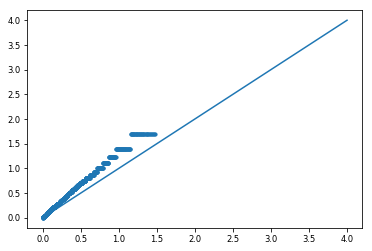

In [967]:
x = np.sort(var_pval)

plt.scatter(
    -np.log10(np.linspace(0, 1, x.shape[0])), 
    -np.log10(x), s=10)

plt.plot([0, 4], [0, 4])

In [791]:
x = np.log(mean_diff.reshape(-1))
y = np.log(var_diff.reshape(-1))
cond = np.isfinite(x) & np.isfinite(y)

In [792]:
stats.spearmanr(x[cond], y[cond])

SpearmanrResult(correlation=-0.06995633237253612, pvalue=0.022048437271494848)

In [700]:
# stats.spearmanr(np.log(mean_diff.reshape(-1)), ))

SyntaxError: invalid syntax (<ipython-input-700-270de557c445>, line 1)

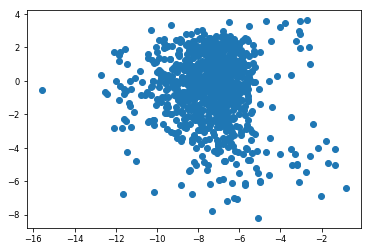

In [701]:
plt.scatter(np.log(mean_diff), np.log(var_diff))

In [365]:
(var_diff > 0).mean()

0.5003915343915344

In [410]:
data = test_adata.X[:, 0].toarray()
counts = np.ones((data.shape[0], 1))
sf = size_factors.reshape(-1, 1)
inv_sf = 1/sf
inv_sf_sq = inv_sf**2

In [463]:
demeaned = ((data*inv_sf)-(data*inv_sf).mean())/inv_sf

In [466]:
devared = np.sqrt((data*inv_sf)**2 - data*inv_sf_sq)

In [473]:
estimator._poisson_1d(
    (data, counts),
    test_adata.X[:, 0].shape[0],
    (inv_sf, inv_sf_sq))

[array([6.30882242]), array([155.02927193])]

In [517]:
temp = np.sqrt((data**2 - data)*inv_sf_sq)

In [518]:
np.var(temp)

159.57168448737485

In [519]:
estimator._poisson_1d(
    (data, counts),
    test_adata.X[:, 0].shape[0],
    (inv_sf, inv_sf_sq))

[array([6.30882242]), array([155.02927193])]

In [493]:
devared = np.sqrt(162.19848963684007)

In [494]:
devared

array([[33.6971479 ],
       [24.12431208],
       [25.1596257 ],
       ...,
       [51.70770074],
       [51.64993029],
       [ 4.11841514]])

In [495]:
demeaned

array([[-5.3264181 ],
       [-4.43703475],
       [-4.54079614],
       ...,
       [ 7.70816903],
       [-6.70416062],
       [ 2.59007539]])

In [496]:
estimator._poisson_1d(
    (devared, counts),
    test_adata.X[:, 0].shape[0],
    (inv_sf, inv_sf_sq))

[array([119.96636018]), array([3406035.08555844])]

In [364]:
# weighting
means_1, vars_1, means_2, vars_2 = [],[],[],[]
for boot_trial in range(num_boot):
    
    means_1.append(moments_1[boot_trial][0])
    vars_1.append(moments_1[boot_trial][1])

    means_2.append(moments_2[boot_trial][0])
    vars_2.append(moments_2[boot_trial][1])
means_1, vars_1, means_2, vars_2 = np.array(means_1), np.array(vars_1), np.array(means_2), np.array(vars_2)
cell_count_1, cell_count_2 = np.array(cell_count_1), np.array(cell_count_2)
actual_cell_count_1 = (test_adata.obs['stim'] == 'ctrl').values.shape[0]
actual_cell_count_2 = (test_adata.obs['stim'] == 'stim').values.shape[0]

actual_mean_diff = (actual_moments_2[0]*actual_cell_count_2 - actual_moments_1[0]*actual_cell_count_1)/(actual_cell_count_1 + actual_cell_count_2)
actual_var_diff =  (actual_moments_2[1]*actual_cell_count_2 - actual_moments_1[1]*actual_cell_count_1)/(actual_cell_count_1 + actual_cell_count_2)

# means_1 -= actual_moments_1[0]
# means_2 -= actual_moments_2[0]
# vars_1 -= actual_moments_1[1]
# vars_2 -= actual_moments_2[1]

mean_diff = (means_2*actual_cell_count_2 - means_1*actual_cell_count_1)/(actual_cell_count_1 + actual_cell_count_2)
mean_diff -= mean_diff.mean(axis=0)

var_diff = (vars_2*actual_cell_count_2 - vars_1*actual_cell_count_1)/(actual_cell_count_1 + actual_cell_count_2)
var_diff -= var_diff.mean(axis=0)

mean_pval = 2*np.minimum(1-(mean_diff > (actual_mean_diff)).mean(axis=0), (mean_diff > (actual_mean_diff)).mean(axis=0))
var_pval = 2*np.minimum(1-(var_diff > (actual_var_diff)).mean(axis=0), (var_diff > (actual_var_diff)).mean(axis=0))

# mean_pval = 2*np.minimum(1-(mean_diff > 0).mean(axis=0), (mean_diff > 0).mean(axis=0))
# var_pval = 2*np.minimum(1-(var_diff > 0).mean(axis=0), (var_diff > 0).mean(axis=0))

In [253]:
# logging
means_1, vars_1, means_2, vars_2 = [],[],[],[]
for boot_trial in range(num_boot):
    
    means_1.append(moments_1[boot_trial][0])
    vars_1.append(moments_1[boot_trial][1])

    means_2.append(moments_2[boot_trial][0])
    vars_2.append(moments_2[boot_trial][1])
means_1, vars_1, means_2, vars_2 = np.array(means_1), np.array(vars_1), np.array(means_2), np.array(vars_2)

actual_mean_diff = np.log(actual_moments_2[0]) - np.log(actual_moments_1[0])
actual_var_diff = np.log(actual_moments_2[1]) - np.log(actual_moments_1[1])

# means_1 -= actual_moments_1[0]
# means_2 -= actual_moments_2[0]
# vars_1 -= actual_moments_1[1]
# vars_2 -= actual_moments_2[1]

mean_diff = np.log(means_2) - np.log(means_1)
mean_diff -= mean_diff.mean(axis=0)

var_diff = np.log(vars_2) - np.log(vars_1)
var_diff -= var_diff.mean(axis=0)

mean_pval = 2*np.minimum(1-(mean_diff > (actual_mean_diff)).mean(axis=0), (mean_diff > (actual_mean_diff)).mean(axis=0))
var_pval = 2*np.minimum(1-(var_diff > (actual_var_diff)).mean(axis=0), (var_diff > (actual_var_diff)).mean(axis=0))

In [ ]:
# weighting
means_1, vars_1, means_2, vars_2 = [],[],[],[]
for boot_trial in range(num_boot):
    
    means_1.append(moments_1[boot_trial][0])
    vars_1.append(moments_1[boot_trial][1])

    means_2.append(moments_2[boot_trial][0])
    vars_2.append(moments_2[boot_trial][1])
means_1, vars_1, means_2, vars_2 = np.array(means_1), np.array(vars_1), np.array(means_2), np.array(vars_2)
cell_count_1, cell_count_2 = np.array(cell_count_1), np.array(cell_count_2)
actual_cell_count_1 = (test_adata.obs['stim'] == 'ctrl').values.shape[0]
actual_cell_count_2 = (test_adata.obs['stim'] == 'stim').values.shape[0]

actual_mean_diff = (actual_moments_2[0]*actual_cell_count_2 - actual_moments_1[0]*actual_cell_count_1)/(actual_cell_count_1 + actual_cell_count_2)
actual_var_diff =  (actual_moments_2[1]*actual_cell_count_2 - actual_moments_1[1]*actual_cell_count_1)/(actual_cell_count_1 + actual_cell_count_2)

# means_1 -= actual_moments_1[0]
# means_2 -= actual_moments_2[0]
# vars_1 -= actual_moments_1[1]
# vars_2 -= actual_moments_2[1]

mean_diff = (means_2*actual_cell_count_2 - means_1*actual_cell_count_1)/(actual_cell_count_1 + actual_cell_count_2)
mean_diff -= mean_diff.mean(axis=0)

var_diff = (vars_2*actual_cell_count_2 - vars_1*actual_cell_count_1)/(actual_cell_count_1 + actual_cell_count_2)
var_diff -= var_diff.mean(axis=0)

mean_pval = 2*np.minimum(1-(mean_diff > (actual_mean_diff)).mean(axis=0), (mean_diff > (actual_mean_diff)).mean(axis=0))
var_pval = 2*np.minimum(1-(var_diff > (actual_var_diff)).mean(axis=0), (var_diff > (actual_var_diff)).mean(axis=0))

In [116]:
mean_diff = means_2 - means_1
# mean_diff -= mean_diff.mean(axis=0)

var_diff = vars_2 - vars_1
# var_diff -= var_diff.mean(axis=0)

mean_pval = np.minimum(1-(mean_diff > 0).mean(axis=0), (mean_diff > 0).mean(axis=0))
var_pval = np.minimum(1-(var_diff > 0).mean(axis=0), (var_diff > 0).mean(axis=0))

In [46]:
mean_pval

array([0.49, 0.04, 0.29, ..., 0.37, 0.22, 0.28])

In [41]:
mean_diff.mean(axis=0).reshape(-1, 1).shape

(1348, 1)

In [39]:
mean_diff.shape

(100, 1348)

In [35]:
actual_moments_1[0][0]

7.145404459221647

In [36]:
means_1.shape

(100, 1348)

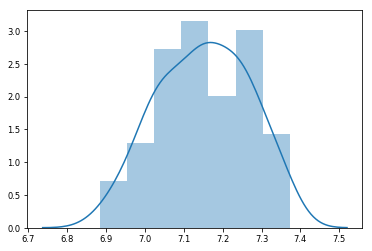

In [33]:
sns.distplot(means_1[:, 0])

### Perform 1D hypothesis testing

In [187]:
util.robust_correlation(
    test_adata.uns['scmemo']['1d_ht']['mean_coef'],
    test_adata.uns['scmemo']['1d_ht']['var_coef']
)

SpearmanrResult(correlation=0.35755907802616516, pvalue=7.034577708071028e-30)

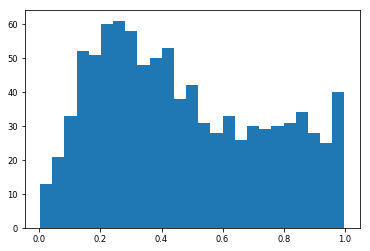

In [188]:
plt.hist(test_adata.uns['scmemo']['1d_ht']['var_asl'], bins=25);

In [189]:
x = np.sort(test_adata.uns['scmemo']['1d_ht']['var_asl'])
# x = np.sort(adata_dict['CD14+ Monocytes'].uns['scmemo']['1d_ht']['var_asl'])

In [190]:
fdr = util._fdrcorrect(x)
print((fdr < 0.1).sum())

0


In [191]:
-np.log10(1/10001)

4.000043427276863

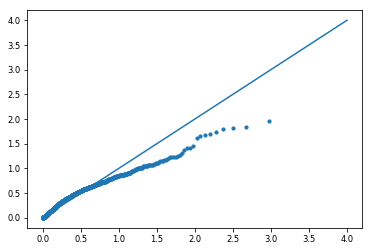

In [192]:
plt.scatter(
    -np.log10(np.linspace(0, 1, x.shape[0])), 
    -np.log10(x), s=10)

plt.scatter(
    -np.log10(np.linspace(0, 1, x.shape[0]))[fdr < 0.1], 
    -np.log10(x)[fdr < 0.1], s=10)
plt.plot([0, 4], [0, 4])

In [179]:
adata_dict = {}
for ct in cts:
    print('Processing:', ct)
    adata_dict[ct] = adata[adata.obs.cell == ct].copy()
    scmemo.create_groups(adata_dict[ct], label_columns=['stim', 'ind'], inplace=True)
    scmemo.compute_1d_moments(adata_dict[ct], inplace=True, filter_genes=True, residual_var=True, use_n_umi=True, filter_mean_thresh=0.07, min_perc_group=.6)
    print('Number of genes kept for {}: {}'.format(ct, adata_dict[ct].shape[1]))
    scmemo.ht_1d_moments(adata_dict[ct], formula_like='1 + stim',cov_column='stim', use_residual_var=True, num_boot=10000, dirichlet_approx=True, log=True, verbose=True)


Processing: CD4 T cells
Number of genes kept for CD4 T cells: 1697
On gene idx 0
On gene idx 300
On gene idx 600
On gene idx 900
On gene idx 1200
On gene idx 1500
Processing: CD14+ Monocytes
Number of genes kept for CD14+ Monocytes: 1952
On gene idx 0
On gene idx 300
On gene idx 600
On gene idx 900
On gene idx 1200
On gene idx 1500
On gene idx 1800
Processing: FCGR3A+ Monocytes
Number of genes kept for FCGR3A+ Monocytes: 2292
On gene idx 0
On gene idx 300
On gene idx 600
On gene idx 900
On gene idx 1200
On gene idx 1500
On gene idx 1800
On gene idx 2100
Processing: NK cells
Number of genes kept for NK cells: 1541
On gene idx 0
On gene idx 300
On gene idx 600
On gene idx 900
On gene idx 1200
On gene idx 1500
Processing: CD8 T cells
Number of genes kept for CD8 T cells: 1453
On gene idx 0
On gene idx 300
On gene idx 600
On gene idx 900
On gene idx 1200
Processing: B cells
Number of genes kept for B cells: 1754
On gene idx 0
On gene idx 300
On gene idx 600
On gene idx 900
On gene idx 1200

### Read the hypothesis test result

In [505]:
adata_dict = {}
for ct in cts:
    adata_dict[ct] = sc.read(data_path + 'result_1d/ifn_{}.h5ad'.format(label_converter[ct]))

### Get a list of ISGF3 and IRF1 bound genes

In [183]:
conversion_df = pd.read_csv('conversion.csv')[['Transcript stable ID', 'Gene name']]
conversion_df.columns = ['transcript_id', 'gene_name']

In [184]:
# isgf3 genes
isgf3_df = pd.read_csv(data_path + 'chipseq/isgf3/isgf3_genes.bed', sep='\t', header=None).iloc[:, [-2, -1]]
isgf3_df.columns=['transcript_id', 'distance']
isgf3_df = isgf3_df.query('distance == 0')
isgf3_df = isgf3_df.merge(conversion_df, on='transcript_id', how='inner')
isgf3_genes = isgf3_df['gene_name'].drop_duplicates().tolist()

In [185]:
ht_result_1d_dict = {}
for ct in cts:
    ht_result_1d_dict[ct] = scmemo.get_1d_ht_result(adata_dict[ct])
    ht_result_1d_dict[ct]['de_fdr'] = util._fdrcorrect(ht_result_1d_dict[ct]['de_pval'])
    ht_result_1d_dict[ct]['dv_fdr'] = util._fdrcorrect(ht_result_1d_dict[ct]['dv_pval'])
    ht_result_1d_dict[ct]['isgf3_binding'] = ht_result_1d_dict[ct]['gene'].apply(lambda x: x in isgf3_genes)
    ht_result_1d_dict[ct]['gene_type'] = ht_result_1d_dict[ct]['isgf3_binding'].apply(lambda x: 'ISGF3' if x else 'upreg')
    ht_result_1d_dict[ct]['ct'] = label_converter[ct]
    
    isfg3_dv = ht_result_1d_dict[ct].query('de_fdr < 0.05 & de_coef > 0 & isgf3_binding')['dv_coef']
    upreg_dv = ht_result_1d_dict[ct].query('de_fdr < 0.05 & de_coef > 0 & ~isgf3_binding')['dv_coef']
    
    print(ct, isfg3_dv.mean(), upreg_dv.mean(), stats.ks_2samp(isfg3_dv, upreg_dv)[1])
ht_result_1d_all = pd.concat([df for ct, df in ht_result_1d_dict.items()])

CD4 T cells -0.08609053616155715 -0.0044818599229671865 0.3003695917647503
CD14+ Monocytes -0.9491175361178692 -0.22827290829031446 1.1379416176016122e-07
FCGR3A+ Monocytes -0.7860962402068066 -0.23148774498895844 1.6804503355505318e-07
NK cells -0.5192243366851585 -0.08426371456973286 0.001939227959120382
CD8 T cells -0.3710467642392982 -0.02563126532356405 0.3582493036423846
B cells -0.46680584858096025 -0.03784498441821733 0.01432405659953484


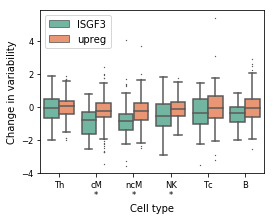

In [396]:
plt.figure(figsize=(4, 3))
sns.boxplot(
    x='ct', y='dv_coef', hue='gene_type',
    data=ht_result_1d_all.query('de_fdr < 0.05 & de_coef > 0'),
    palette=sns.color_palette('Set2'),
    fliersize=0.5)
#plt.plot([-1, 6], [0, 0], '--', lw=1, color='k')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5], labels=['Th', 'cM\n*', 'ncM\n*', 'NK\n*', 'Tc', 'B'])
plt.xlabel('Cell type'); plt.ylabel('Change in variability');
plt.legend(loc='upper left')
plt.savefig(fig_path + 'isgf3_vs_rest.pdf', bbox_inches='tight')

### DE effect size vs DV effect size by cell type

In [409]:
def plot_de_dv(ct, result_df):
    
    de_diff = result_df['de_coef']
    dv_diff = result_df['dv_coef']
    de_fdr = result_df['de_fdr']
    dv_fdr = result_df['dv_fdr']
    
    sig = (de_fdr < 0.1) & (dv_fdr < 0.1)
    plt.plot([0, 0], [-4, 2.5], '--', lw=2, color='k')
    plt.plot([-3, 5], [0, 0], '--', lw=2, color='k')
    plt.scatter(de_diff[~sig], dv_diff[~sig], s=1, color='grey')
    plt.scatter(de_diff[sig], dv_diff[sig], s=5, color='g')
        
    plt.xlabel('$\Delta$Mean')
    if ct in ['NK cells', 'CD4 T cells']:
        plt.ylabel('$\Delta$Variability')
    
    print(ct, util.robust_correlation(de_diff, dv_diff))

    plt.title(ct)
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
    plt.gca().yaxis.set_major_locator(plt.MultipleLocator(2))

CD4 T cells SpearmanrResult(correlation=-0.034163827382245826, pvalue=0.15950424077772812)
CD14+ Monocytes SpearmanrResult(correlation=-0.29675109219710094, pvalue=6.443611112182711e-41)
FCGR3A+ Monocytes SpearmanrResult(correlation=-0.1978321868816221, pvalue=2.017560407208486e-21)


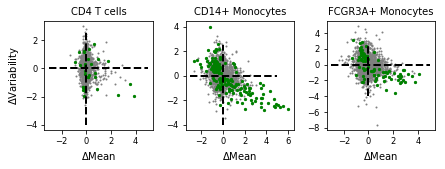

In [410]:
plt.figure(figsize=(7, 2))
plt.subplots_adjust(hspace=0.45, wspace=0.3)
for idx, ct in enumerate(cts[:3]):
    plt.subplot(1, 3, idx+1)
    plot_de_dv(ct, ht_result_1d_dict[ct])
plt.savefig(fig_path + 'de_vs_dv.png', bbox_inches='tight')
    

### Single gene example

In [402]:
def plot_bar_strip(gene, ct_to_include=None):
    
    ct_list = cts if ct_to_include is None else ct_to_include
    expr_df_list = []
    for ct in ct_list:
        if gene in adata_dict[ct].var.index:
            gene_idx = adata_dict[ct].var.index.tolist().index(gene)
            for group in adata_dict[ct].uns['scmemo']['groups']:
                expr_df_list.append((label_converter[ct], group.split('^')[0], group.split('^')[1], np.log(adata_dict[ct].uns['scmemo']['1d_moments'][group][0][gene_idx]), adata_dict[ct].uns['scmemo']['1d_moments'][group][2][gene_idx]))
    expr_df = pd.DataFrame(expr_df_list, columns=['ct','ind', 'stim', 'mean', 'variability'])

    plt.figure(figsize=(3, 3))
    plt.subplots_adjust(hspace=0.1)

    plt.subplot(2, 1, 1)
    plt.title('{} expression in response to IFN-B'.format(gene))

    ax = sns.boxplot(x='ct', y='mean', data=expr_df, hue='stim', palette=sns.color_palette('Set2'))
    ax = sns.stripplot(x='ct', y='mean', data=expr_df, hue='stim', dodge=True, palette=sns.color_palette('Set2'), edgecolor='grey', linewidth=2)
    handles, labels = ax.get_legend_handles_labels()
    l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xticks([]); plt.xlabel('')

    plt.subplot(2, 1, 2)
    ax = sns.boxplot(x='ct', y='variability', data=expr_df, hue='stim', palette=sns.color_palette('Set2'))
    ax = sns.stripplot(x='ct', y='variability', data=expr_df, hue='stim', dodge=True, palette=sns.color_palette('Set2'), edgecolor='grey', linewidth=2)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend_.remove()

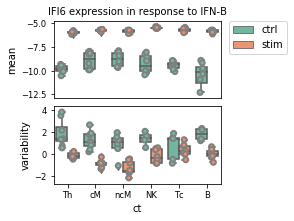

In [403]:
plot_bar_strip('IFI6', ct_to_include=None)
plt.savefig(fig_path + 'across_ct_{}.pdf'.format('IFI6'), bbox_inches='tight')

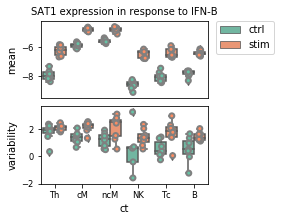

In [404]:
plot_bar_strip('SAT1', ct_to_include=None)
plt.savefig(fig_path + 'across_ct_{}.pdf'.format('SAT1'), bbox_inches='tight')

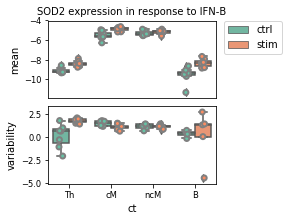

In [405]:
# plot_bar_strip('LGALS3', ct_to_include=['CD14+ Monocytes', 'FCGR3A+ Monocytes'])
plot_bar_strip('SOD2', ct_to_include=None)
plt.savefig(fig_path + 'across_ct_{}.pdf'.format('SOD2'), bbox_inches='tight')

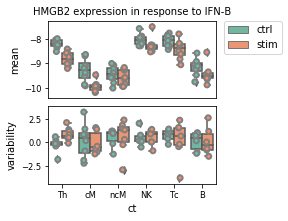

In [406]:
plot_bar_strip('HMGB2', ct_to_include=None)
plt.savefig(fig_path + 'across_ct_{}.pdf'.format('HMGB2'), bbox_inches='tight')

### P-value calibrations

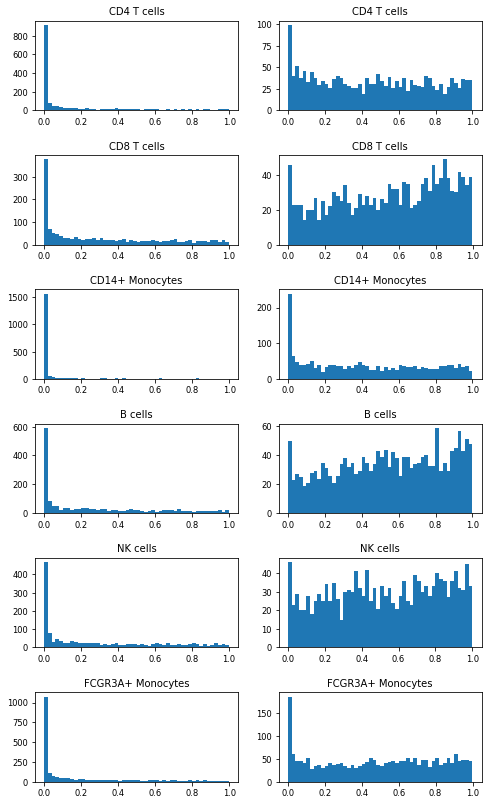

In [413]:
plt.figure(figsize=(8, 14))
plt.subplots_adjust(hspace=0.5)

for idx, ct in enumerate(['CD4 T cells', 'CD8 T cells', 'CD14+ Monocytes', 'B cells', 'NK cells', 'FCGR3A+ Monocytes']):
    
    plt.subplot(6, 2, 2*idx+1);
    plt.hist(adata_dict[ct].uns['scmemo']['1d_ht']['mean_asl'], bins=50);
    plt.title('{}'.format(ct))
    
    plt.subplot(6, 2, 2*idx+2);
    plt.hist(adata_dict[ct].uns['scmemo']['1d_ht']['var_asl'], bins=50);
    plt.title('{}'.format(ct))
plt.savefig('de_dv_calibration.pdf', bbox_inches='tight')

***